# Artificial Neural Network Example/Excercise

This notebook is an exercise in using Artificial Neural Networks to **CLASSIFY** the MNIST handwritten digit data set (the "Hello, World" of ML datasets).

## Table of contents:

* [Imported Libraries](#imports)
* [Loading MNIST Dataset](#load)
  - [Viewing the data](#view)
* [Preprocess the data](#preprocess)
  - [Reshape and normalize image data](#reshape)
  - [Process the labels](#labels)
* [Flat neural network](#simple)
  - [Define model architecture](#model)
  - [Evaluate model](#simple-evaluate)
* [Flat: Adam](#simple-adam)
* [Flat: Dense](#simple-dense)
* [Simple convolutional](#conv-simple)
* [Multi-layer convolutional network](#conv-simple)

# Imported Libraries <a class="anchor" id="imports"></a>

Start by importing the following libraries.

**NOTE:**

- Versions for keras, tensorflow, scikit-learn
    * You may install these versions in anaconda *via* `$: conda install keras=2.2.2`
- If you have an Nvidia gpu, you can install gpu-enabled versions of tensorflow/keras for improved performance:
    * `$: conda install -c defaults tensorflow-gpu keras-gpu`
    * **NOTE:** As of 2018-10-02 the conda-forge versions of the above were not working with my GPU (Quadro P5000)

In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(123)
from matplotlib import pyplot as plt

import keras
print(f"keras version: {keras.__version__}")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
import tensorflow
print(f"tensorflow version: {tensorflow.__version__}")

import os

import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
from sklearn import metrics

Using TensorFlow backend.


keras version: 2.2.2
tensorflow version: 1.10.0
scikit-learn version: 0.20.0


# Load MNIST Dataset <a class="anchor" id="load"></a>

In this example we will use the MNIST dataset from keras. This dataset is nx28x28 in size, and is already nicely split into training and testing data

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)


## Visualize the training data <a class="anchor" id="view"></a>

Let's view a few examples of the handwritten images

<IPython.core.display.Javascript object>


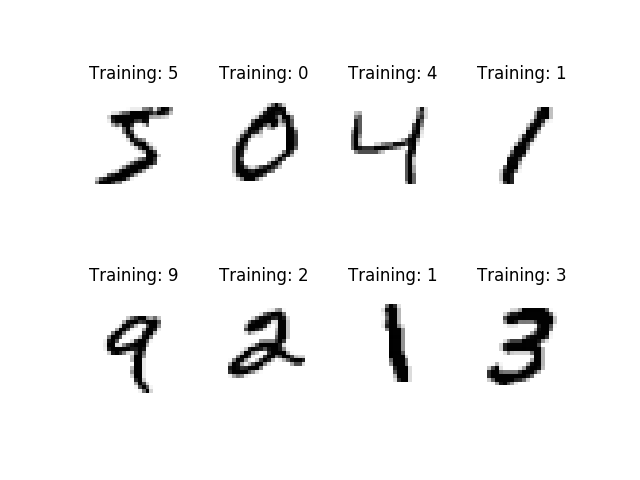

In [3]:
fig = plt.figure()
for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    ax.axis('off')
    ax.imshow(X_train[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title("Training: {}".format(y_train[i]))
plt.show()

# Preprocess the data <a class="anchor" id="preprocess"></a>

Before we can start to build and train our neural network, we first need to preprocess the data so that the keras framework can understand and interpret it

## Reshape and normalize image data <a class="anchor" id="reshape"></a>

"Typical" image data is RGB and would have a shape Nx28x28x3. This data is greyscale, so the shape needs to be Nx28x28x1. Our data is only Nx28x28, so we need to add an additional dimension for Keras to appropriately handle

We will alsoconvert to float32 and normalize the inputs to [0,1]. While this isn't strictly necessary, normalizing input data tends to improve performance

In [4]:
# reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# cast to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize inputs
X_train /= 255
X_test /= 255

## Process the labels <a class="anchor" id="labels"></a>

As provided, the labels are directly associated with the data, i.e.

`y_train[9] = 4 # the 10th data point is an image of a "4"`

Because the output of our neural network will be 10 neurons, each associated with a digit, we need the labels to be categorized: rather than `y_train[9] = 4`, we need `y_train[9] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`

We use `np_utils.to_categorical` to achieve this

In [5]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# Flat Neural Network <a class="anchor" id="simple"></a>

Now we will define the architecture of our model. 

## Define model <a class="anchor" id="model"></a>

Let's start with an extremely simple Neural Net. Similar to the SVM example, we will operate on a flat array, so that

<IPython.core.display.Javascript object>


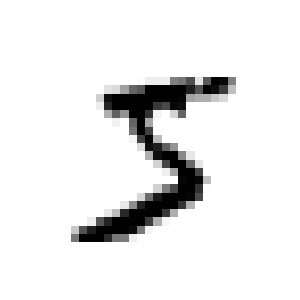

In [6]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.axis('off')
ax.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

becomes

<IPython.core.display.Javascript object>


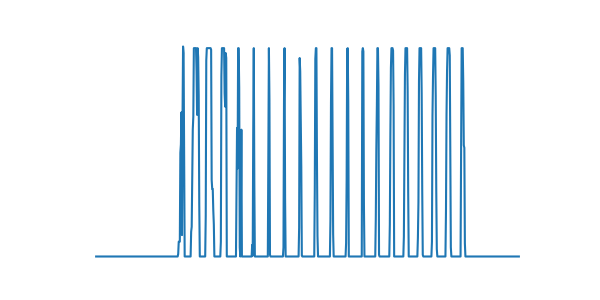

In [7]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.axis('off')
ax.plot(X_train[0].reshape(-1))
plt.show()

### First Layer: Flat

We start with a flat input layer:

In [36]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))

### Second Layer: Dense

The second layer is a dense (fully connected) layer. We will only use 16 nodes. We will also use one of the simplest nonlinear activation functions, sigmoid.

**NOTE:** We are taking an input of $28*28=784$ nodes and piping those into only $16$ nodes. This is done on purpose to limit the effectiveness of the neural network for demonstration purposes.

In [37]:
model.add(Dense(16, activation='sigmoid'))

### Output Layer:

The final layer consists of 10 nodes, corresponding to the 10 different digits. We use the `softmax` activation funciton to force there only being a single node active for each set of data (this makes sense because each image can only be a single number

In [38]:
model.add(Dense(10, activation='softmax'))

### Compile model:

We need to set a few more parameters:

1. Loss function: this defines the function that will measure the performance of the neural network. Many loss functions are available. Because we are classifying (categorizing), we will use the `categorical_crossentropy` loss function
2. Optimizer: Defines the method the neural network will use to optimize its performance. We will use the simple `Stochastic Gradient Descent`
3. Metrics: `accuracy` is the basic metric, and it is all we will use here

In [11]:
model.compile(loss='categorical_crossentropy', optimizer="sgd", metrics=['accuracy'])

### Model Summary:

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


### Fit the model

Now, we will actually train the model! We specify the number of samples to be collected before updating the network weights (`batch_size`) and the number of times we iterate over the entire dataset (`epochs`).

In [13]:
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

Epoch 1/10
60000/60000 [==============================] - 9s 143us/step - loss: 1.8190 - acc: 0.5708
Epoch 2/10
60000/60000 [==============================] - 7s 113us/step - loss: 1.0897 - acc: 0.7832
Epoch 3/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.7810 - acc: 0.8325
Epoch 4/10
60000/60000 [==============================] - 9s 143us/step - loss: 0.6354 - acc: 0.8574
Epoch 5/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.5497 - acc: 0.8735
Epoch 6/10
60000/60000 [==============================] - 7s 123us/step - loss: 0.4928 - acc: 0.8826
Epoch 7/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.4525 - acc: 0.8888
Epoch 8/10
60000/60000 [==============================] - 9s 149us/step - loss: 0.4226 - acc: 0.8943
Epoch 9/10
60000/60000 [==============================] - 9s 152us/step - loss: 0.3997 - acc: 0.8976
Epoch 10/10
60000/60000 [==============================] - 9s 145us/step - loss: 0.3814 - a

## Evaluate model <a class="anchor" id="simple-evaluate"></a>

Let's consider the performance of the model

In [14]:
score = model.evaluate(X_test, y_test)
print(f"loss = {score[0]}, accuracy={score[1]}")

10000/10000 [==============================] - 1s 54us/step
loss = 0.36354167070388793, accuracy=0.9052


### Analyze the confusion matrix

A nice way to understand and analyze the performance of a classification ML tool is a confusion matrix. Such a matrix displays the probability of accurately predicting a given category (diagonal), as well as incorrectly predicting a given category (off-diagonal)

<IPython.core.display.Javascript object>


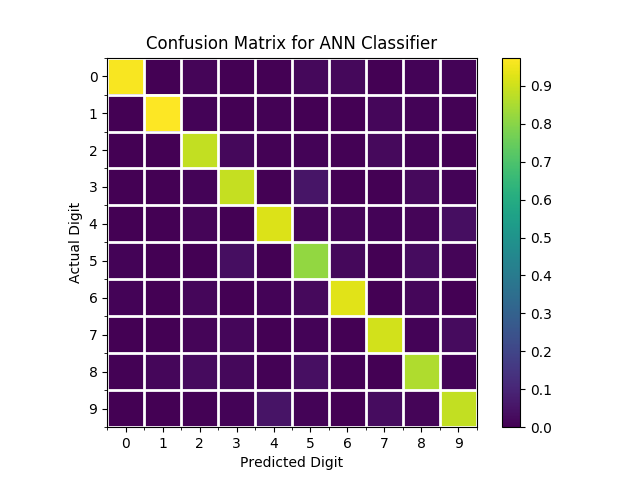

In [15]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

## Summary <a class="anchor" id="simple-summary"></a>

Our very simple neural net has an overall accuracy of around 90%, detailed here

In [16]:
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fc31c562780>:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.95      0.97      0.96      1135
           2       0.92      0.88      0.90      1032
           3       0.90      0.89      0.89      1010
           4       0.90      0.92      0.91       982
           5       0.86      0.82      0.84       892
           6       0.91      0.93      0.92       958
           7       0.92      0.91      0.91      1028
           8       0.86      0.86      0.86       974
           9       0.88      0.88      0.88      1009

   micro avg       0.91      0.91      0.91     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.91      0.90     10000


Confusion matrix:
[[ 947    0    3    2    1   10   10    2    5    0]
 [   0 1106    2    3    1    1    3    1   18    0]
 [  15    8  913

Let's try to dig in a bit (see [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) for more information)

#### Precision

Precision is $t_p \; / \; \left(t_p + f_p\right)$, the ratio of true positives to all predicted positives. This is the ability to avoid a false positive

#### Recall

Recall is $t_p \; / \; \left(t_p + f_n\right)$, the ratio of true positives to all values that should be positive. This is the ability to find the correct number of positives

#### F-score

f1-score is a weighted mean of the precision and recall. A perfect score is 1, and its worst is 0. This weighting can be adjusted with the `beta` parameter. `beta` defaults to 1, meaning recall and precision are equally important. This score will weight recall more than precision by a factor of `beta`

While we are alright overall, and better than the out-of-the-box SVM, we can do better

We also specify that we will have 32 filters to train i.e. 32 different "patterns" that will be learnt

## Flat improvement: ADAM optimizer <a class="anchor" id="simple-adam"></a>

Epoch 1/10
60000/60000 [==============================] - 10s 160us/step - loss: 0.8581 - acc: 0.8011
Epoch 2/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.3508 - acc: 0.9092
Epoch 3/10
60000/60000 [==============================] - 10s 173us/step - loss: 0.2744 - acc: 0.9236
Epoch 4/10
60000/60000 [==============================] - 10s 172us/step - loss: 0.2402 - acc: 0.9311
Epoch 5/10
60000/60000 [==============================] - 10s 170us/step - loss: 0.2193 - acc: 0.9368
Epoch 6/10
60000/60000 [==============================] - 10s 165us/step - loss: 0.2048 - acc: 0.9407
Epoch 7/10
60000/60000 [==============================] - 10s 169us/step - loss: 0.1935 - acc: 0.9447
Epoch 8/10
60000/60000 [==============================] - 10s 173us/step - loss: 0.1833 - acc: 0.9472
Epoch 9/10
60000/60000 [==============================] - 10s 166us/step - loss: 0.1754 - acc: 0.9488
Epoch 10/10
60000/60000 [==============================] - 10s 161us/step - loss: 0

<IPython.core.display.Javascript object>


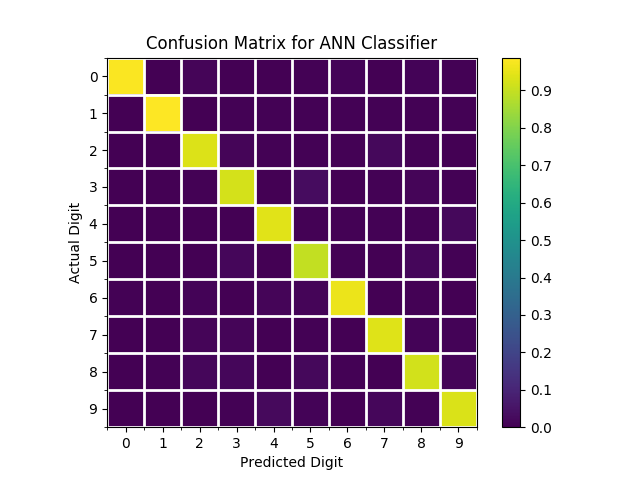

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fc318cdb978>:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.94      0.93      0.93      1010
           4       0.95      0.95      0.95       982
           5       0.94      0.90      0.92       892
           6       0.95      0.96      0.95       958
           7       0.94      0.94      0.94      1028
           8       0.92      0.92      0.92       974
           9       0.94      0.93      0.93      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000


Confusion matrix:
[[ 963    0    0    1    3    3    6    2    2    0]
 [   0 1121    4    2    0    0    2    1    5    0]
 [  13    3  966

In [17]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
# model.add(Dense(28*28, activation='relu'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)
model.summary()
score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

We see quite an improvement simply by changing our optimizer. But we can do better

## More flat improvements: Increase number of second layer nodes <a class="anchor" id="flat-dense"></a>

Lets use 64

Epoch 1/10
60000/60000 [==============================] - 8s 135us/step - loss: 0.3008 - acc: 0.9151
Epoch 2/10
60000/60000 [==============================] - 10s 162us/step - loss: 0.1420 - acc: 0.9584
Epoch 3/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.1026 - acc: 0.9696
Epoch 4/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.0799 - acc: 0.9755
Epoch 5/10
60000/60000 [==============================] - 10s 168us/step - loss: 0.0663 - acc: 0.9795
Epoch 6/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0551 - acc: 0.9830
Epoch 7/10
60000/60000 [==============================] - 10s 170us/step - loss: 0.0457 - acc: 0.9863
Epoch 8/10
60000/60000 [==============================] - 10s 170us/step - loss: 0.0395 - acc: 0.9879
Epoch 9/10
60000/60000 [==============================] - 9s 147us/step - loss: 0.0347 - acc: 0.9893
Epoch 10/10
60000/60000 [==============================] - 8s 135us/step - loss: 0.029

<IPython.core.display.Javascript object>


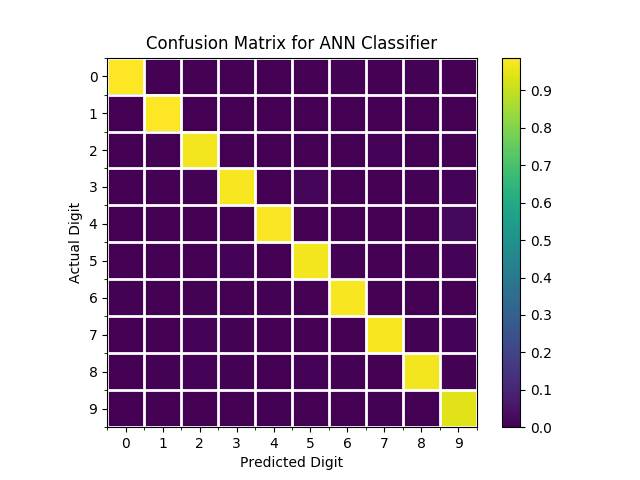

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fc300717ba8>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.96      0.97      0.96       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.98      0.94      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Confusion matrix:
[[ 968    0    1    1    0    3    4    2    1    0]
 [   0 1121    4    1    0    1    2    1    5    0]
 [   3    1 1000

In [18]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)
model.summary()
score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

That's very impressive...but we can do much better with a convolutional model

# Simple Convolutional Model <a class="anchor" id="conv-simple"></a>

Let's start with a very simple convolutional model:

1. Convolutional Layer to handle the image
2. Output Layer

## Convolution Animation <a class="anchor" id="conv-ani"></a>

We will be using a multi-layer neural net to learn handwritten digits. Because the input images are 2D, and because of their relative strength in learning images, we will use convolutional layers to learn our model.

By passing a 3x3 kernel over the 28x28 image, we end up with an output image of 26x26 (see how this results below)

<IPython.core.display.Javascript object>


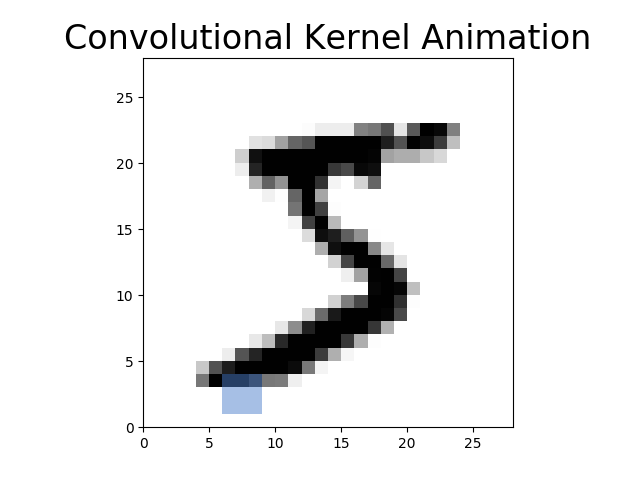

In [19]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111)
im_arr = X_train[0].reshape(28, 28)
ax.imshow(im_arr, extent=(0, 28, 0, 28), cmap=plt.cm.gray_r, vmin=0, vmax=1)
ax.set_title("Convolutional Kernel Animation", fontsize=24)
kernel_arr = np.zeros((28, 28, 4))
kernel_arr[:3, :3, :] = [0.3, 0.5, 0.8, 0.5]
im = ax.imshow(kernel_arr, extent=(0, 28, 0, 28), vmin=0, vmax=1)

ani_i = 0
ani_j = 0

def updatefig(*args):
    global im_arr, ax
    global ani_i, ani_j
    # increment j
    ani_j += 1
    # increment i once j resets
    ani_i = ani_i + 1 if (ani_j%26 == 0) else ani_i
    # handle periodic boundaries
    ani_j = ani_j % 26
    ani_i = ani_i % 26
    kernel_arr = np.zeros((28, 28, 4))
    kernel_arr[ani_i:ani_i+3, ani_j:ani_j+3, :] = [0.3, 0.5, 0.8, 0.5]
    im.set_array(kernel_arr)
    return im,

# display animation
ani = animation.FuncAnimation(fig, updatefig, blit=True, interval=20, repeat=True)
ax.set_xlim((0, 28))
ax.set_ylim((0, 28))
plt.show()

Epoch 1/10
60000/60000 [==============================] - 13s 211us/step - loss: 0.1787 - acc: 0.9490
Epoch 2/10
60000/60000 [==============================] - 10s 175us/step - loss: 0.0687 - acc: 0.9799
Epoch 3/10
60000/60000 [==============================] - 10s 161us/step - loss: 0.0480 - acc: 0.9851
Epoch 4/10
60000/60000 [==============================] - 11s 190us/step - loss: 0.0357 - acc: 0.9888
Epoch 5/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.0274 - acc: 0.9914
Epoch 6/10
60000/60000 [==============================] - 9s 158us/step - loss: 0.0200 - acc: 0.9941
Epoch 7/10
60000/60000 [==============================] - 10s 159us/step - loss: 0.0151 - acc: 0.9954
Epoch 8/10
60000/60000 [==============================] - 11s 180us/step - loss: 0.0122 - acc: 0.9964
Epoch 9/10
60000/60000 [==============================] - 11s 189us/step - loss: 0.0091 - acc: 0.9970
Epoch 10/10
60000/60000 [==============================] - 11s 182us/step - loss: 0

<IPython.core.display.Javascript object>


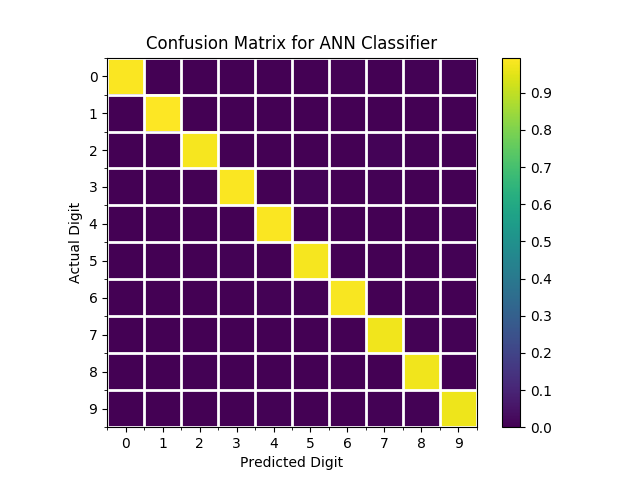

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fc3001bdf60>:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.97      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.98      1009

   micro avg       0.98      0.98      0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Confusion matrix:
[[ 968    0    3    1    1    2    3    0    2    0]
 [   0 1129    2    0    2    0    0    1    1    0]
 [   2    3 1011

In [20]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)
model.summary()
score = model.evaluate(X_test, y_test)
print(score)
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

# Mulit-layer Convolutional Neural Network <a class="anchor" id="conv-multi"></a>

Now let's improve with more layers...not like actually needs to be improved 

In [21]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

## Add more layers

We'll add yet another convolutional layer. Then, we'll have a 2x2 kernel pass over the previous layer, taking the max of the 4 values. Finally, a dropout layer will be added to accelerate back-propogation of weights and help prevent overfitting. Very briefly, dropout helps improve training by periodically deactivating neurons during training, preventing two neurons from effectively blindly passing values along without taking the activation of other connecting neurons into account

In [22]:
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

## Complete the network

We now flatten the network into a single dimension, add a fully connected layer, and then our output layer. Because we are classifying, the final layer will have as many nodes as our classes (10). We use the `softmax` activation function to enforce that only one node activates in the output layer

In [23]:
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model

Declare the loss function, optimizer, etc.

In [24]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

## Train the network/Fit the data

Train the network and save; training takes O(10 min) on a CPU, and O(2 min) on a GPU.

In [25]:
# load the data
load = True
if not (os.path.exists("keras_mnist_ann.h5") and os.path.exists("keras_mnist_ann.json") and load):
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)
    # save model
    model_json = model.to_json()
    with open("keras_mnist_ann.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("keras_mnist_ann.h5")
else:
    json_file = open("keras_mnist_ann.json", "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(loaded_model_json)
    model.load_weights("keras_mnist_ann.h5")
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# Evaluate model on test data

In [26]:
model.summary()
score = model.evaluate(X_test, y_test)
print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

# View Confusion Matrix

<IPython.core.display.Javascript object>


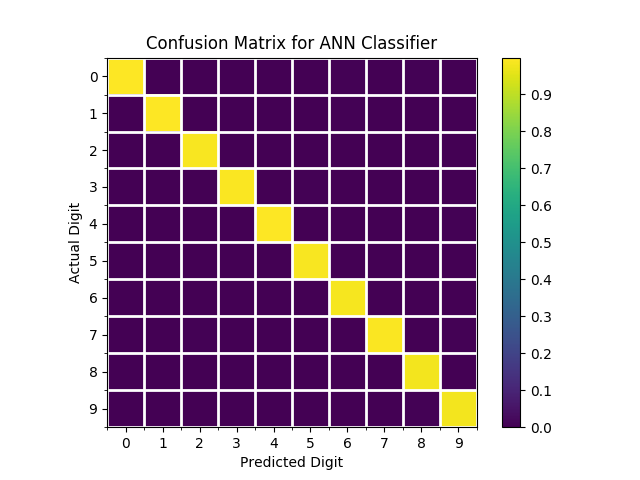

Classification report for classifier <keras.engine.sequential.Sequential object at 0x7fc2d0276898>:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Confusion matrix:
[[ 979    0    0    0    0    0    0    1    0    0]
 [   0 1133    1    0    0    1    0    0    0    0]
 [   2    2 1020

In [27]:
y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm = cm_norm.T

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm_norm, interpolation='nearest')

ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

cbar = fig.colorbar(cax, ticks=[i for i in np.arange(0, 1, 0.1)])

ax.set_xlabel("Predicted Digit")
ax.set_ylabel("Actual Digit")
ax.set_title(r"Confusion Matrix for ANN Classifier")

plt.show()

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

# Summary <a class="anchor" id="summary"></a>

| Network | Accuracy |
| ------------- |-----:|
| Flat-SGB  | 0.9052   |
| Flat-ADAM | 0.9397 |
| Flat-Dense | 0.9722 |
| Conv-Simple | 0.981 |
| Conv-Multilayer | 0.9913 |


Compare to SVM/SVC performance:

| SVM | Accuracy |
| ------------- |-----:|
| SVC | 0.8883 |

# Visualizing the Neural Network layers

Artificial neural networks are often referred to as "black boxes" because the weighting and outputs of the layers are not easy to view (and as we will see, are not necessarily easy to inuit/interpret when we can).

Here we create another neural net, this time with 3 convolutional layers before a maxpooling layer. We will then view the output of each layer after training when supplied with an image.

In [41]:
model = Sequential()

model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
convout1 = Activation('relu')
model.add(convout1)

model.add(Convolution2D(32, (3, 3), activation='relu'))
convout2 = Activation('relu')
model.add(convout2)

model.add(Convolution2D(32, (3, 3), activation='relu'))
convout3 = Activation('relu')
model.add(convout3)

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
maxout = Activation('relu')
model.add(maxout)

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_data=(X_test, y_test))

model.summary()
score = model.evaluate(X_test, y_test)
print(score)

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
print("Confusion matrix:\n%s" % cm)

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 76us/step - loss: 0.2482 - acc: 0.9237 - val_loss: 0.0505 - val_acc: 0.9838
Epoch 2/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0883 - acc: 0.9744 - val_loss: 0.0384 - val_acc: 0.9865
Epoch 3/10
60000/60000 [==============================] - 4s 67us/step - loss: 0.0668 - acc: 0.9797 - val_loss: 0.0312 - val_acc: 0.9892
Epoch 4/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.0543 - acc: 0.9837 - val_loss: 0.0329 - val_acc: 0.9893
Epoch 5/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.0484 - acc: 0.9858 - val_loss: 0.0275 - val_acc: 0.9910
Epoch 6/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.0402 - acc: 0.9869 - val_loss: 0.0235 - val_acc: 0.9922
Epoch 7/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.0373 - acc: 0.9883 - val_loss: 0.0236 - val_acc

In [50]:
# choose any image to want by specifying the index
img_to_visualize = X_train[1]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

def layer_to_visualize(layer, my_title):
    """
    compute the output of the convolutional and maxpool layers
    
    requires the use of particular backend flags to turn off
    training behavior
    """
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    # technically this is "backward" from the original example
    # this is because we are using a slightly different API to
    # pass our images into the network
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.axis('off')
        ax.imshow(convolutions[:,:,i], cmap='gray')
    fig.suptitle(my_title, fontsize=24)

Shape of conv: (26, 26, 32)


<IPython.core.display.Javascript object>


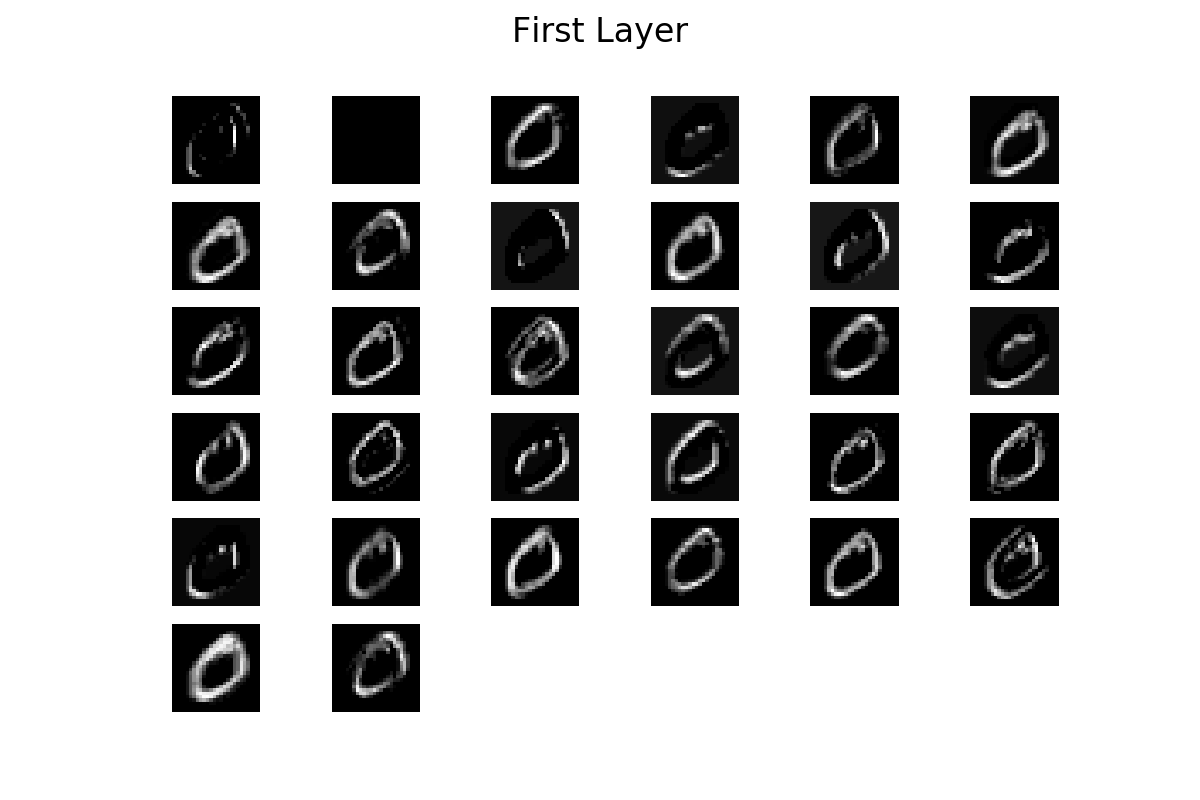

Shape of conv: (24, 24, 32)


<IPython.core.display.Javascript object>


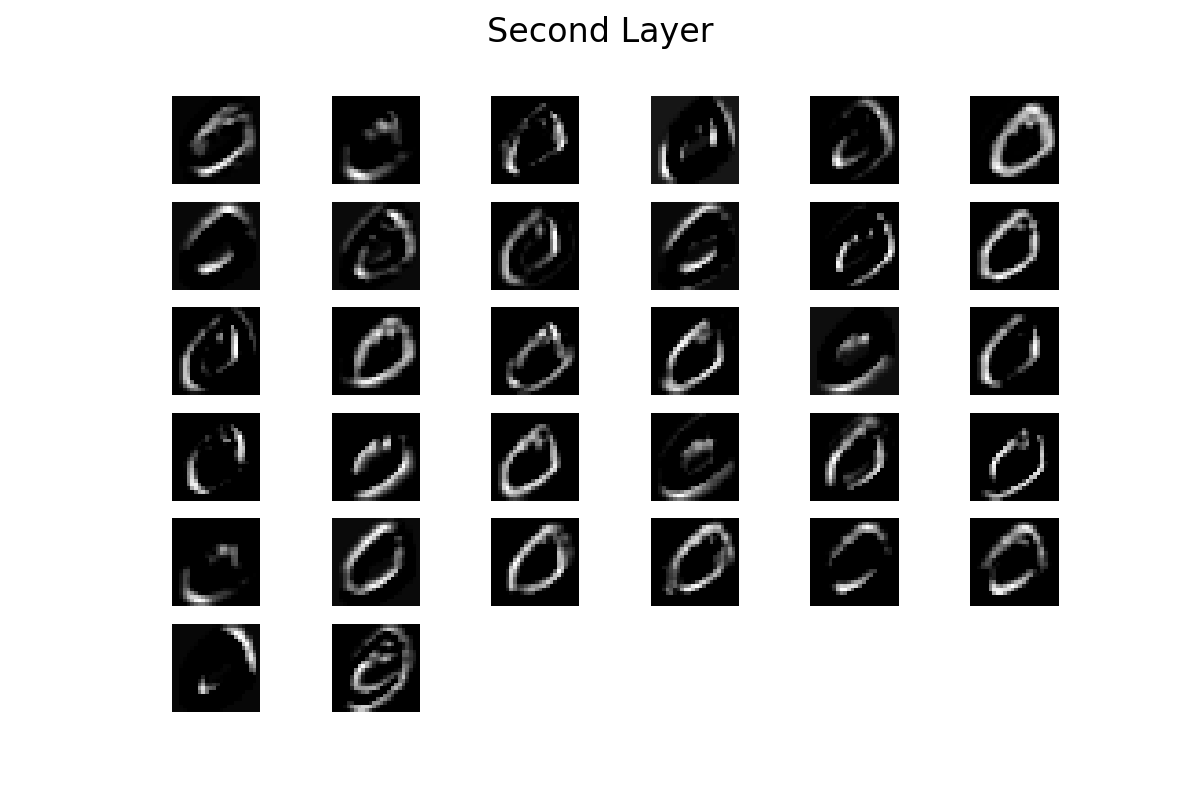

Shape of conv: (22, 22, 32)


<IPython.core.display.Javascript object>


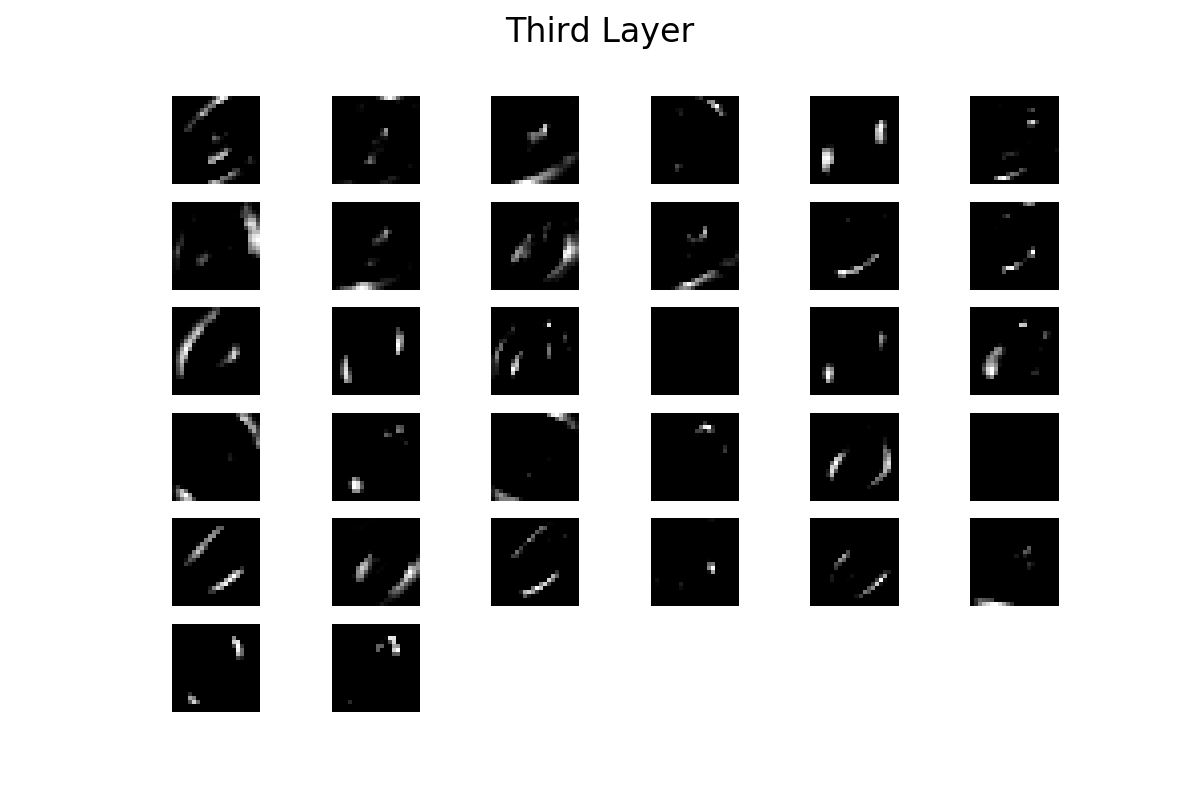

Shape of conv: (11, 11, 32)


<IPython.core.display.Javascript object>


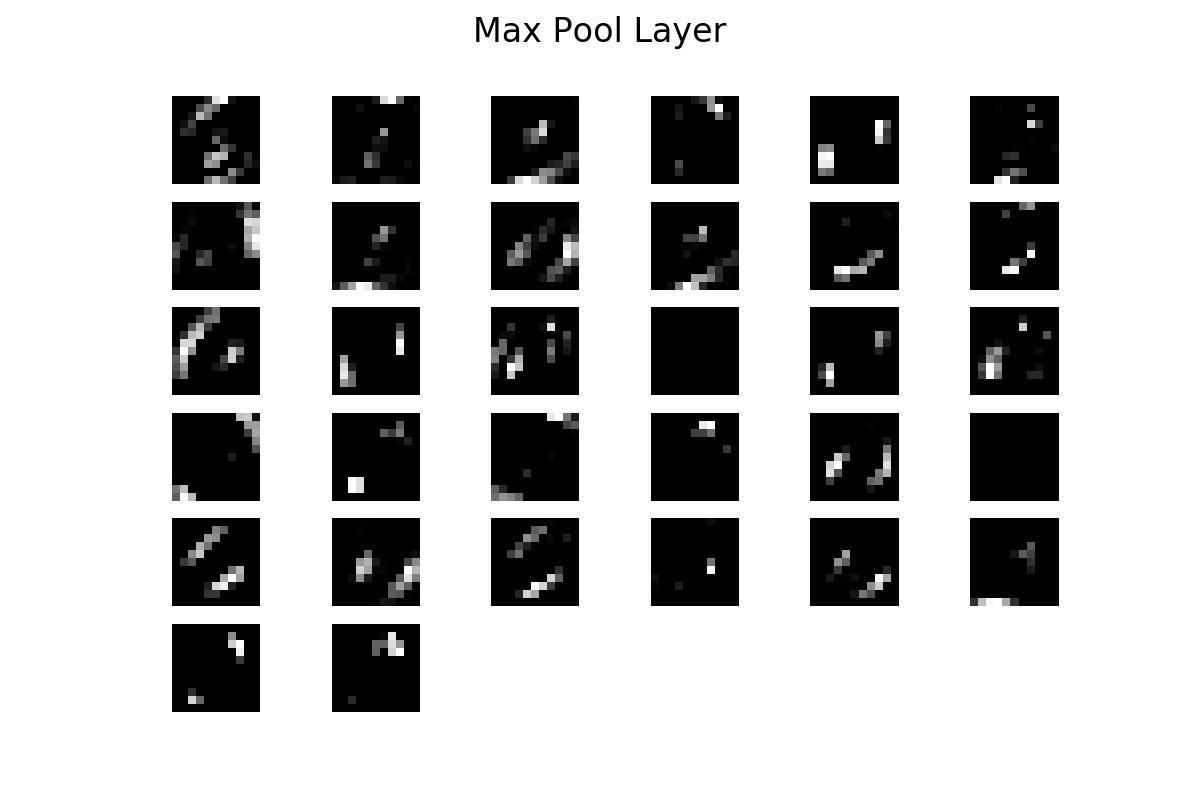

In [51]:
# Specify the layer to want to visualize
layer_to_visualize(convout1, "First Layer")

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2, "Second Layer")

layer_to_visualize(convout3, "Third Layer")

layer_to_visualize(maxout, "Max Pool Layer")



## Original Visualization Example

[Link to original example](https://github.com/yashk2810/Visualization-of-Convolutional-Layers/blob/master/Visualizing%20Filters%20Python3%20Theano%20Backend.ipynb)

In [31]:
# Model 
new_model = Sequential()

new_model.add(Convolution2D(32, (3, 3), input_shape=(28,28,1))) 
convout1 = Activation('relu')
new_model.add(convout1)
convout2 = MaxPooling2D()
new_model.add(convout2)

new_model.add(Flatten())

new_model.add(Dense(128))
new_model.add(Activation('relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(10))
new_model.add(Activation('softmax'))

new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
new_model.fit(X_train, y_train, batch_size=128, nb_epoch=5, validation_data=(X_test, y_test))

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.2471 - acc: 0.9279 - val_loss: 0.0825 - val_acc: 0.9753
Epoch 2/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0793 - acc: 0.9765 - val_loss: 0.0548 - val_acc: 0.9810
Epoch 3/5
60000/60000 [==============================] - 4s 63us/step - loss: 0.0545 - acc: 0.9835 - val_loss: 0.0489 - val_acc: 0.9838
Epoch 4/5
60000/60000 [==============================] - 3s 55us/step - loss: 0.0431 - acc: 0.9869 - val_loss: 0.0456 - val_acc: 0.9844
Epoch 5/5
60000/60000 [==============================] - 3s 53us/step - loss: 0.0341 - acc: 0.9897 - val_loss: 0.0365 - val_acc: 0.9881


In [48]:
# choose any image to want by specifying the index
img_to_visualize = X_train[1]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)
print(img_to_visualize.shape)
# print(new_model.inputs)

def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + new_model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')

(1, 28, 28, 1)


In [49]:
# Specify the layer to want to visualize
layer_to_visualize(convout1)

# # As convout2 is the result of a MaxPool2D layer
# # We can see that the image has blurred since
# # the resolution has reduced 
layer_to_visualize(convout2)



InvalidArgumentError: You must feed a value for placeholder tensor 'conv2d_8_input' with dtype float and shape [?,28,28,1]
	 [[Node: conv2d_8_input = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: activation_8/Relu/_1037 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_21_activation_8/Relu", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]